# Analyzing my spotify saved tracks

For a while now I have been an avid user of Spotify, I just love the endless library to explore and discover new music. The Spotify team made that even easier by rolling out the "Discover Weekly" playlist, which is a impressively accurate representation of a user's recent listening patterns. Let's try to build something similar.

This little project consist of two (three) parts:
* Exploratory analysis; Visualize my preference in music, and compare to Global Top 50.
* Recommender engine

Off we go!

N.B. This notebook is accompanied by a python script using the Spotipy library to authenticate with the Spotify API and retrieve the audio features of the songs in a playlist.

### Part I: Explore

Import the necessary libraries:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
# import hypertools as hyp
%matplotlib inline  

sns.set_style("darkgrid")

Load the csv audio data into a Dataframe.

In [2]:
features_df = pd.read_csv('1112028701-5fSGPkcoJNxUoRraRcJ9WQ.csv')

Use the dataframe head, info and describe to get an initial view of the data entries and properties of data set.

In [3]:
features_df.head()

,id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,type,uri
0,6nz8W5q940pEthdQfjwYhh,0.213,0.101,134.968,0.0329,0.882000,0.851000,3,0.354,2,198444,-16.463,0.158,0,audio_features,spotify:track:6nz8W5q940pEthdQfjwYhh
1,7sBRwgYSf6dwyIi9T6uY7y,0.223,0.114,109.466,0.0651,0.970000,0.888000,4,0.758,8,213637,-13.275,0.265,1,audio_features,spotify:track:7sBRwgYSf6dwyIi9T6uY7y
2,4PYoRZpEoJHAi22nbeGA0b,0.844,0.238,119.987,0.0407,0.000186,0.539000,4,0.539,1,199800,-5.604,0.466,1,audio_features,spotify:track:4PYoRZpEoJHAi22nbeGA0b
3,3JCvbJlquC5ZhdXhHq62Z5,0.991,0.290,83.995,0.0960,0.000018,0.000000,4,0.477,5,192261,-2.692,0.364,0,audio_features,spotify:track:3JCvbJlquC5ZhdXhHq62Z5
4,3tyFkV691mLN162OMYP5Vi,0.659,0.118,106.913,0.0293,0.002110,0.000017,4,0.573,3,266947,-5.271,0.204,0,audio_features,spotify:track:3tyFkV691mLN162OMYP5Vi


In [4]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 16 columns):
id                  705 non-null object
energy              705 non-null float64
liveness            705 non-null float64
tempo               705 non-null float64
speechiness         705 non-null float64
acousticness        705 non-null float64
instrumentalness    705 non-null float64
time_signature      705 non-null int64
danceability        705 non-null float64
key                 705 non-null int64
duration_ms         705 non-null int64
loudness            705 non-null float64
valence             705 non-null float64
mode                705 non-null int64
type                705 non-null object
uri                 705 non-null object
dtypes: float64(9), int64(4), object(3)
memory usage: 88.2+ KB


In [5]:
features_df.describe()

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode
count,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000
mean,0.693043,0.184952,124.726033,0.064389,0.169982,0.166389,3.919149,0.548540,5.489362,268839.582979,-7.211206,0.454392,0.551773
std,0.218178,0.155091,26.948960,0.058233,0.269039,0.305278,0.325069,0.167452,3.475599,87209.176094,3.420787,0.227066,0.497665
min,0.056300,0.015600,68.992000,0.023200,0.000004,0.000000,1.000000,0.154000,0.000000,55973.000000,-24.738000,0.035600,0.000000
25%,0.546000,0.097000,105.821000,0.034200,0.001820,0.000002,4.000000,0.432000,2.000000,212310.000000,-8.966000,0.279000,0.000000
50%,0.748000,0.121000,123.781000,0.044800,0.019700,0.000572,4.000000,0.548000,6.000000,244720.000000,-6.485000,0.433000,1.000000
75%,0.873000,0.221000,140.049000,0.066000,0.223000,0.138000,4.000000,0.671000,9.000000,304560.000000,-4.626000,0.628000,1.000000
max,0.997000,0.991000,245.997000,0.497000,0.979000,0.950000,5.000000,0.928000,11.000000,759360.000000,-1.606000,0.966000,1.000000


Let's see what the average value of each audio feature is across the playlist

(0.0, 0.5)

/Users/thompijnenburg/anaconda/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['Proxima Nova'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


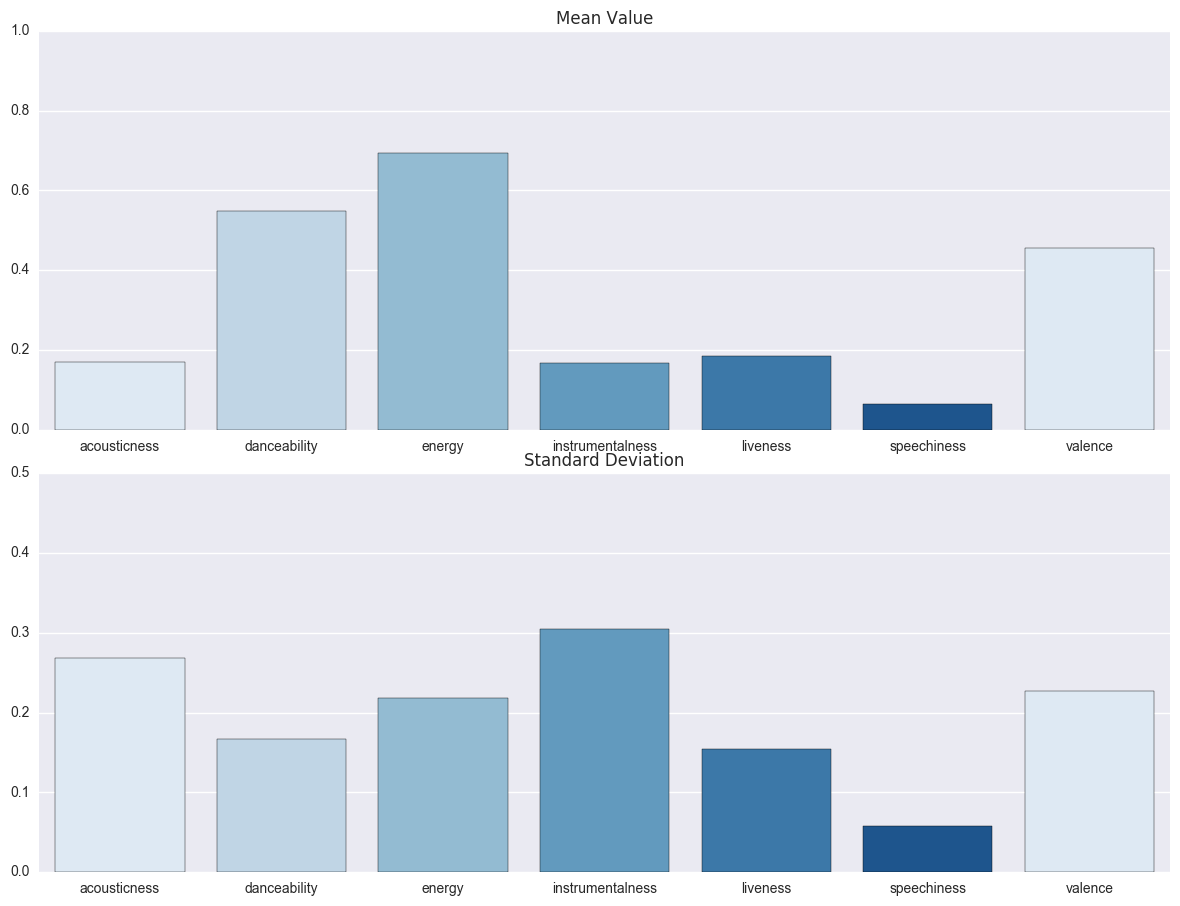

In [6]:
# Grab the columns we are interested in
feature_columns = ['energy', 'liveness', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'valence']
mean_values = {}
std_values = {}

hfont = {'fontname':'Proxima Nova'}

# Compute mean value and std for feature columns
for feature in feature_columns:
    mean = features_df[feature].mean()
    mean_values[feature] = [mean]
    std = features_df[feature].std()
    std_values[feature] = [std]

# Construct dataframe
feature_means_df = pd.DataFrame(data=mean_values)
std_values_df = pd.DataFrame(data=std_values)

# Initiate plot
f, axes = plt.subplots(2, 1, figsize=(12, 9))
plt.tight_layout()

# Prepare mean value barplot
feature_plot = sns.barplot(data=feature_means_df, palette=sns.color_palette("Blues"), ax=axes[0])
feature_plot.set_title('Mean Value', **hfont)
feature_plot.set_ylim(0.0, 1)

# Prepapre std deviation barplot
std_plot = sns.barplot(data=std_values_df, palette=sns.color_palette("Blues"), ax=axes[1])
std_plot.set_title('Standard Deviation', **hfont)
std_plot.set_ylim(0.0, 0.5)

We will get better insight of the complete set by looking at the distribution of values of each audio feature. First create a new DataFrame that is limited to the entries we are interested in.

In [7]:
cleaned_feature_df = features_df.drop(['tempo', 'time_signature', 'key', 'duration_ms', 'mode', 'type', 'loudness'], axis=1)
cleaned_feature_df.head(10)

,id,energy,liveness,speechiness,acousticness,instrumentalness,danceability,valence,uri
0,6nz8W5q940pEthdQfjwYhh,0.213,0.101,0.0329,0.882000,0.851000,0.354,0.158,spotify:track:6nz8W5q940pEthdQfjwYhh
1,7sBRwgYSf6dwyIi9T6uY7y,0.223,0.114,0.0651,0.970000,0.888000,0.758,0.265,spotify:track:7sBRwgYSf6dwyIi9T6uY7y
2,4PYoRZpEoJHAi22nbeGA0b,0.844,0.238,0.0407,0.000186,0.539000,0.539,0.466,spotify:track:4PYoRZpEoJHAi22nbeGA0b
3,3JCvbJlquC5ZhdXhHq62Z5,0.991,0.290,0.0960,0.000018,0.000000,0.477,0.364,spotify:track:3JCvbJlquC5ZhdXhHq62Z5
4,3tyFkV691mLN162OMYP5Vi,0.659,0.118,0.0293,0.002110,0.000017,0.573,0.204,spotify:track:3tyFkV691mLN162OMYP5Vi
5,29lBMAu32Yaooj3QdzKwMO,0.949,0.316,0.0730,0.000012,0.002340,0.413,0.364,spotify:track:29lBMAu32Yaooj3QdzKwMO
6,24l3sA2bx0DdM9d4pfgywU,0.878,0.225,0.0407,0.003460,0.000022,0.486,0.316,spotify:track:24l3sA2bx0DdM9d4pfgywU
7,1JIEHfirWnJETcZZegwqXD,0.460,0.337,0.0307,0.223000,0.000728,0.469,0.390,spotify:track:1JIEHfirWnJETcZZegwqXD
8,250Y5ghha5UHY1mMgWZ2nD,0.299,0.108,0.0391,0.901000,0.950000,0.386,0.832,spotify:track:250Y5ghha5UHY1mMgWZ2nD
9,0ec5rFBAAB1rbC4qqqYazX,0.436,0.139,0.0344,0.404000,0.309000,0.722,0.379,spotify:track:0ec5rFBAAB1rbC4qqqYazX


Now we can plot the distributions:

/Users/thompijnenburg/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


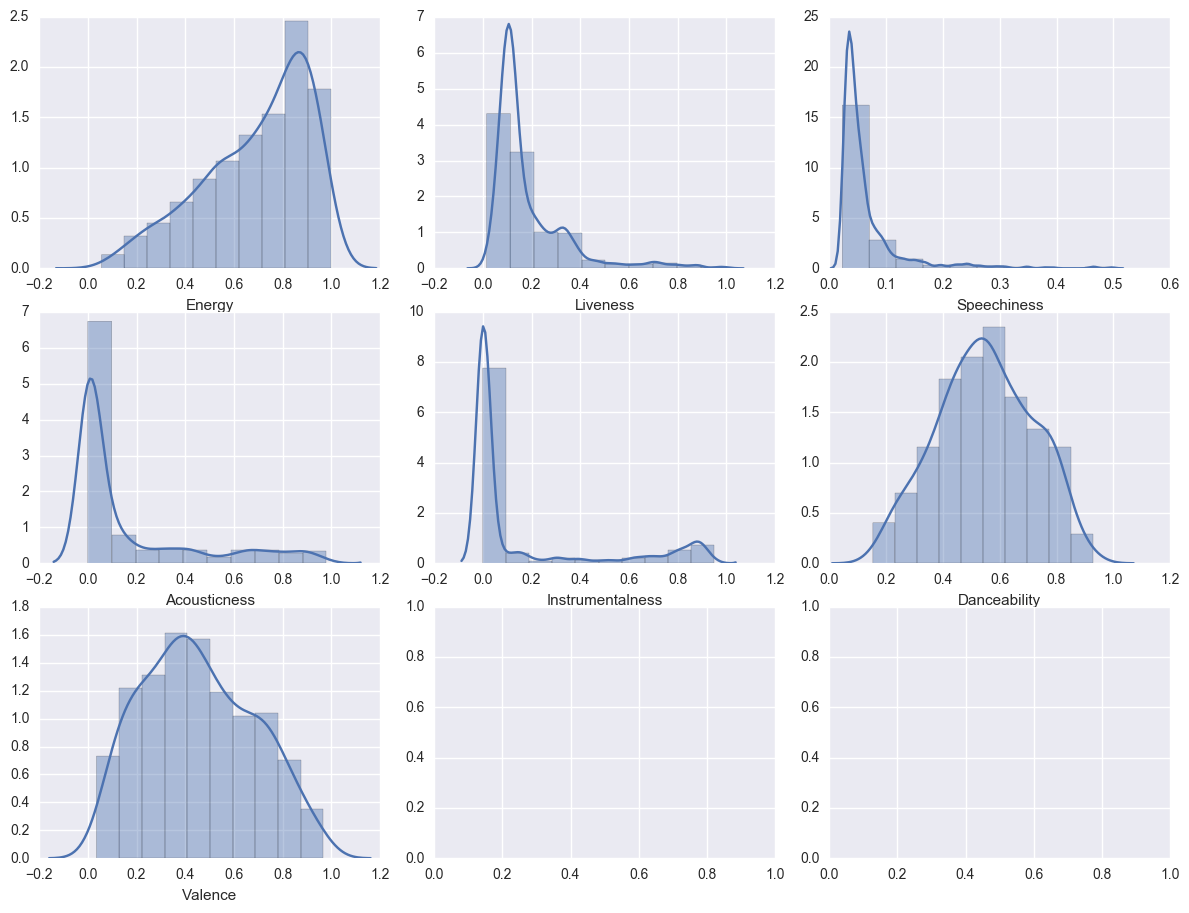

In [8]:
f, axes = plt.subplots(3, 3, figsize=(12, 9))
plt.tight_layout()

sns.distplot(cleaned_feature_df['energy'], bins=10, ax=axes[0,0]).set_xlabel('Energy')
sns.distplot(cleaned_feature_df['liveness'], bins=10, ax=axes[0,1]).set_xlabel('Liveness')
sns.distplot(cleaned_feature_df['speechiness'], bins=10, ax=axes[0,2]).set_xlabel('Speechiness')
sns.distplot(cleaned_feature_df['acousticness'], bins=10, ax=axes[1,0]).set_xlabel('Acousticness')
sns.distplot(cleaned_feature_df['instrumentalness'], bins=10, ax=axes[1,1]).set_xlabel('Instrumentalness')
sns.distplot(cleaned_feature_df['danceability'], bins=10, ax=axes[1,2]).set_xlabel('Danceability')
sns.distplot(cleaned_feature_df['valence'], bins=10, ax=axes[2,0]).set_xlabel('Valence')

**Intermediate conclusion**

These graphs are quite telling of the playlist contents. Firstly, *Speechiness*, *Acousticness* and *Instrumentallness* are very narrowly distributed near the zero value, I guess I don't care saving songs that do have these properties. On the other hand, its quite obvious that I like a lot of *Energy* in my songs, that *Danceability* is fairly normally distributed and that *Valence* is a little off-center to the left, on the more angsty side of the spectrum.  

**Global Top 50**

Now let's compare this with the spotify global top 50

In [9]:
global_df = pd.read_csv('spotifycharts-37i9dQZEVXbMDoHDwVN2tF.csv');
cleaned_global_df = global_df.drop(['tempo', 'time_signature', 'key', 'duration_ms', 'mode', 'type', 'loudness'], axis=1)

global_df.head()

,id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,type,uri
0,7wGoVu4Dady5GV0Sv4UIsx,0.522,0.1420,159.772,0.0984,0.13000,0.000090,4,0.577,5,218320,-6.594,0.119,0,audio_features,spotify:track:7wGoVu4Dady5GV0Sv4UIsx
1,0ofbQMrRDsUaVKq2mGLEAb,0.517,0.1040,104.992,0.0312,0.18600,0.000038,4,0.768,7,216897,-4.323,0.418,0,audio_features,spotify:track:0ofbQMrRDsUaVKq2mGLEAb
2,5UEnHoDYpsxlfzWLZIc7LD,0.748,0.0759,90.052,0.4730,0.17000,0.000000,4,0.757,8,221013,-5.794,0.693,0,audio_features,spotify:track:5UEnHoDYpsxlfzWLZIc7LD
3,2ekn2ttSfGqwhhate0LSR0,0.696,0.1790,116.054,0.0755,0.00256,0.000010,4,0.771,9,208827,-6.258,0.656,0,audio_features,spotify:track:2ekn2ttSfGqwhhate0LSR0
4,7EmGUiUaOSGDnUUQUDrOXC,0.802,0.1770,124.989,0.0394,0.13900,0.000000,4,0.715,11,197993,-4.647,0.327,0,audio_features,spotify:track:7EmGUiUaOSGDnUUQUDrOXC


/Users/thompijnenburg/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


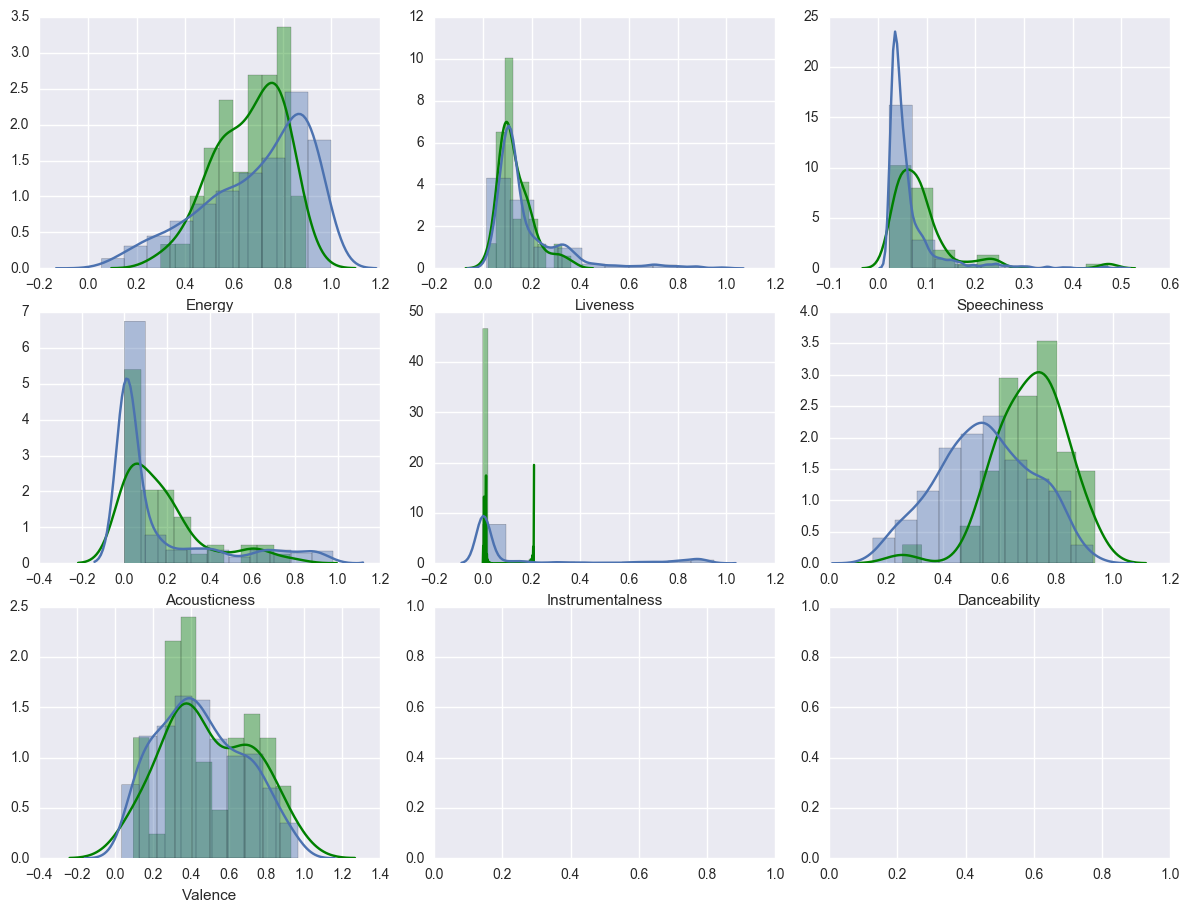

In [10]:
# Plot

feature_cols = ['energy', 'liveness', 'speechiness', 'acousticness', 'instrumentalness', 'danceability', 'valence']

f, axes = plt.subplots(3, 3, figsize=(12, 9))
plt.tight_layout()

idx = 0;
for i in range(0,3):
    for j in range(0,3): 
        if idx == len(feature_cols):
            break
        feature_ij = feature_cols[idx];
        sns.distplot(cleaned_global_df[feature_ij], bins=10, ax=axes[i,j], color='g').set_xlabel(feature_ij.capitalize())
        sns.distplot(cleaned_feature_df[feature_ij], bins=10, ax=axes[i,j]).set_xlabel(feature_ij.capitalize())
        idx += 1

These histograms give a great view of the differences between the two data sets. For example, songs in my playlist tend to have a lot of *Energy* so that distribution is skewed all the way to the right (1.0), while the energy distribution in the global top 50 is centered around 0.7-0.8 buckets. If we look at *Danceability* though, the globe tends to like songs with a higher danceability score, which can be explained by the fact that there is quite a bit of influence from the dance scene in Pop music nowadays.

__Note__ that including the kde in these histograms already turns the data into a density, so the difference in size between the two datasets (700 vs. 50) is compensated for!

## Clustering by K-means

In [11]:
from sklearn.cluster import KMeans

In [12]:
kmeans = KMeans(n_clusters=10)

In [13]:
kmeans.fit(cleaned_feature_df.drop(['id', 'uri'], axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [14]:
kmeans.cluster_centers_

array([[ 0.29517857,  0.12399286,  0.04788214,  0.75285714,  0.76960714,
         0.50417857,  0.23322857],
       [ 0.56058929,  0.13370536,  0.07786429,  0.10088934,  0.05940595,
         0.71253571,  0.49041964],
       [ 0.66976923,  0.15812115,  0.05705192,  0.04274808,  0.82201923,
         0.65401923,  0.23667692],
       [ 0.78010345,  0.70075862,  0.11042069,  0.11092231,  0.03917703,
         0.46162069,  0.50603448],
       [ 0.72787755,  0.13007347,  0.06403673,  0.06376142,  0.74938776,
         0.69806122,  0.65004082],
       [ 0.81014754,  0.16710328,  0.06419754,  0.06380283,  0.0171232 ,
         0.64382787,  0.75832787],
       [ 0.49479592,  0.12809184,  0.0585898 ,  0.56320408,  0.04212831,
         0.63657143,  0.57581633],
       [ 0.88327072,  0.17408729,  0.0785    ,  0.01270465,  0.02503535,
         0.43317127,  0.40651934],
       [ 0.31431346,  0.20881154,  0.03852308,  0.75138462,  0.01607138,
         0.49319231,  0.27523269],
       [ 0.64966667,  0.1779

In [15]:
kmeans.labels_

array([0, 0, 4, 7, 9, 7, 7, 9, 0, 6, 7, 7, 6, 9, 7, 4, 7, 5, 9, 9, 4, 0, 7,
       6, 1, 5, 5, 0, 2, 1, 7, 6, 7, 7, 7, 9, 1, 7, 4, 5, 7, 7, 9, 7, 0, 7,
       2, 2, 7, 8, 7, 0, 1, 7, 6, 7, 1, 7, 7, 6, 5, 0, 7, 7, 4, 0, 2, 9, 7,
       7, 5, 7, 6, 7, 4, 7, 8, 6, 9, 1, 6, 8, 3, 5, 4, 4, 5, 1, 1, 0, 1, 7,
       7, 5, 7, 8, 0, 7, 7, 8, 0, 6, 2, 4, 2, 5, 7, 5, 9, 0, 8, 8, 6, 6, 9,
       0, 7, 3, 2, 6, 6, 2, 5, 9, 3, 7, 7, 7, 0, 4, 9, 6, 6, 8, 9, 5, 7, 7,
       8, 9, 8, 6, 6, 6, 6, 7, 5, 7, 8, 5, 5, 6, 3, 0, 3, 2, 8, 8, 5, 6, 0,
       6, 9, 2, 7, 7, 3, 9, 2, 5, 5, 9, 0, 9, 3, 0, 0, 8, 0, 9, 5, 8, 1, 6,
       1, 1, 7, 1, 8, 7, 6, 4, 4, 1, 7, 4, 5, 4, 9, 0, 7, 1, 7, 9, 7, 1, 7,
       6, 2, 7, 7, 7, 5, 7, 9, 6, 8, 8, 8, 4, 7, 5, 1, 8, 1, 1, 6, 4, 7, 7,
       9, 7, 2, 9, 9, 7, 7, 9, 1, 8, 8, 6, 4, 1, 2, 9, 7, 8, 4, 2, 4, 4, 7,
       7, 1, 8, 5, 3, 4, 9, 6, 1, 7, 7, 7, 7, 5, 6, 7, 5, 7, 7, 7, 9, 9, 9,
       7, 1, 7, 7, 7, 8, 5, 5, 8, 5, 9, 4, 5, 2, 4, 3, 5, 2, 2, 5, 9, 7, 5,
       7, 3,

In [16]:
clustered_features_df = cleaned_feature_df
clustered_features_df['cluster'] = kmeans.labels_

In [17]:
clustered_features_df.head()

,id,energy,liveness,speechiness,acousticness,instrumentalness,danceability,valence,uri,cluster
0,6nz8W5q940pEthdQfjwYhh,0.213,0.101,0.0329,0.882000,0.851000,0.354,0.158,spotify:track:6nz8W5q940pEthdQfjwYhh,0
1,7sBRwgYSf6dwyIi9T6uY7y,0.223,0.114,0.0651,0.970000,0.888000,0.758,0.265,spotify:track:7sBRwgYSf6dwyIi9T6uY7y,0
2,4PYoRZpEoJHAi22nbeGA0b,0.844,0.238,0.0407,0.000186,0.539000,0.539,0.466,spotify:track:4PYoRZpEoJHAi22nbeGA0b,4
3,3JCvbJlquC5ZhdXhHq62Z5,0.991,0.290,0.0960,0.000018,0.000000,0.477,0.364,spotify:track:3JCvbJlquC5ZhdXhHq62Z5,7
4,3tyFkV691mLN162OMYP5Vi,0.659,0.118,0.0293,0.002110,0.000017,0.573,0.204,spotify:track:3tyFkV691mLN162OMYP5Vi,9


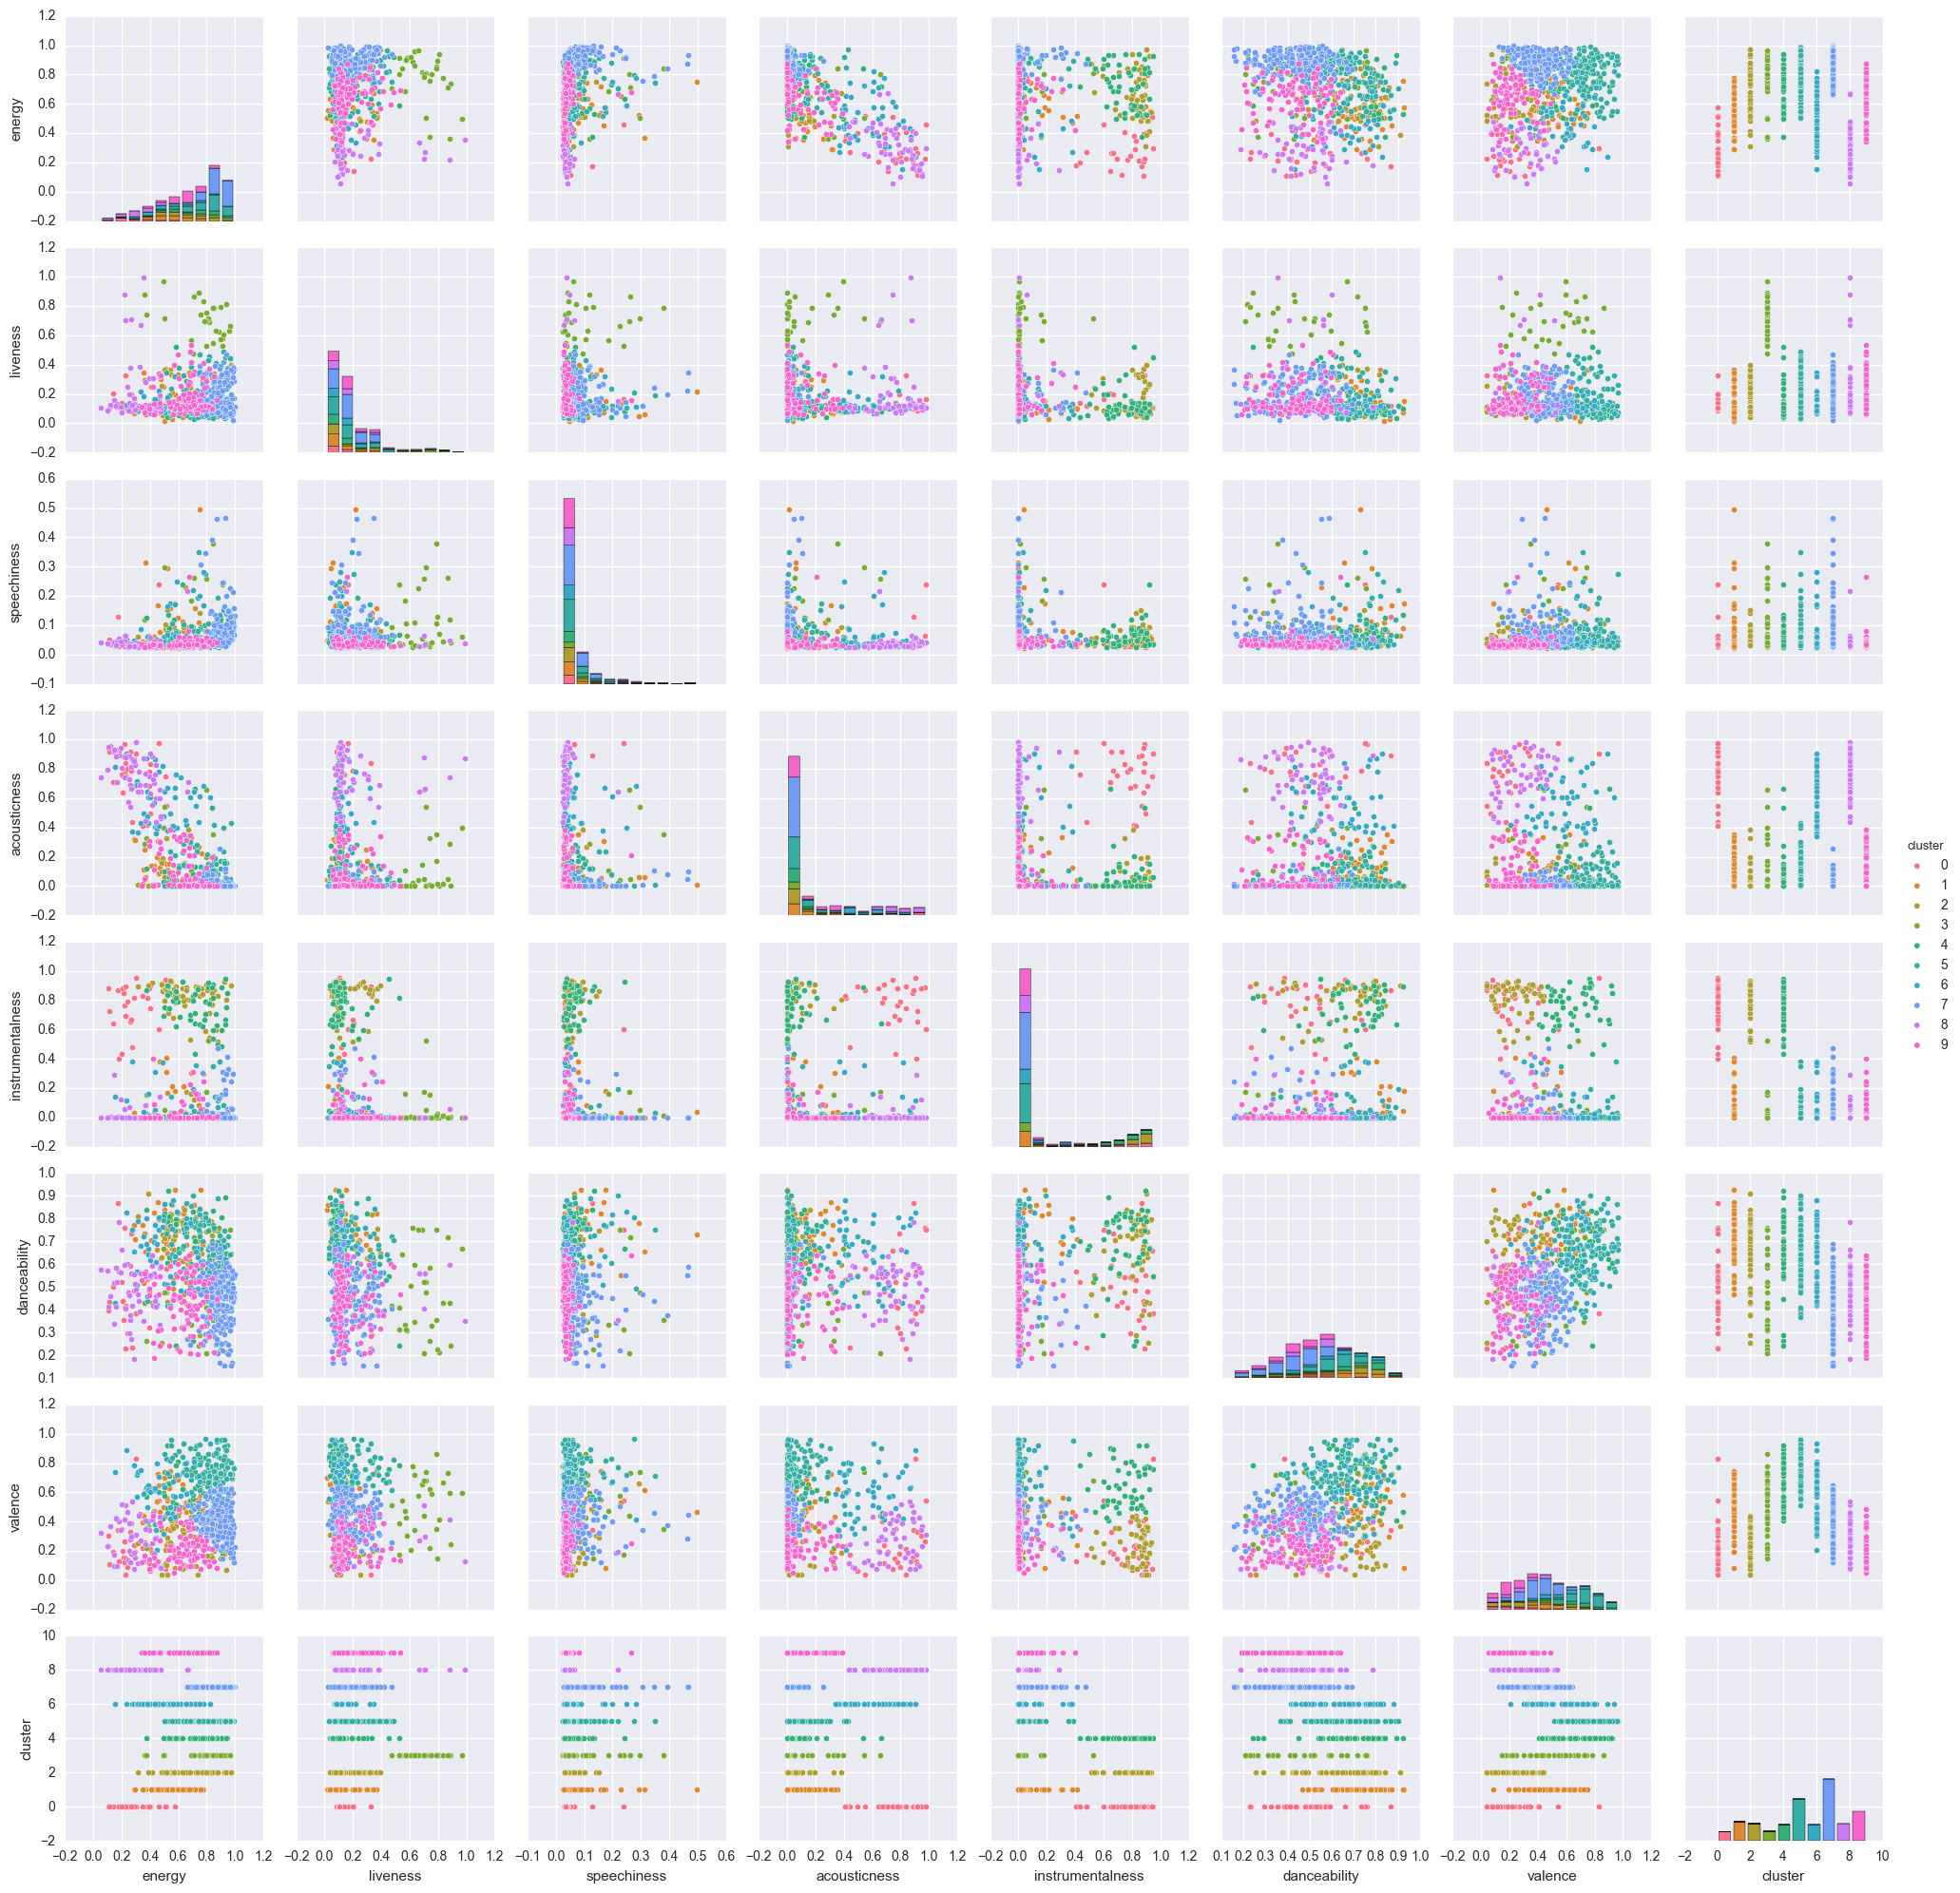

In [18]:
sns.pairplot(clustered_features_df, hue="cluster")

Since we are looking at a 7 dimensional parameter space, it is difficult to see how well our clustering has performed. Let us first isolate cluster 1 and see how its properties look like.

In [19]:
cluster_1_df = clustered_features_df[clustered_features_df['cluster'] == 1]

In [20]:
cluster_1_df.head(10)

,id,energy,liveness,speechiness,acousticness,instrumentalness,danceability,valence,uri,cluster
24,552NkuaDuJDCNIkWor3O0f,0.656,0.0755,0.0298,0.00712,0.000012,0.686,0.469,spotify:track:552NkuaDuJDCNIkWor3O0f,1
29,5euZhKKAW8EkK9PhPJDJLW,0.564,0.1100,0.0503,0.04910,0.000090,0.540,0.490,spotify:track:5euZhKKAW8EkK9PhPJDJLW,1
36,2c6JKsE4PPXOtlD5ehbVIS,0.362,0.2930,0.0307,0.25100,0.022600,0.734,0.260,spotify:track:2c6JKsE4PPXOtlD5ehbVIS,1
52,77yoRTrDsrK7ch9di7QPaB,0.776,0.0690,0.0430,0.00184,0.299000,0.697,0.457,spotify:track:77yoRTrDsrK7ch9di7QPaB,1
56,0h847iYHZVRg8ojqwnLjk4,0.498,0.2480,0.0264,0.16600,0.000000,0.701,0.498,spotify:track:0h847iYHZVRg8ojqwnLjk4,1
79,6Sm7K81Dqggxz0cuTWZFro,0.524,0.0868,0.0420,0.11200,0.001430,0.785,0.349,spotify:track:6Sm7K81Dqggxz0cuTWZFro,1
87,4vELW2hK9eb9R7Q0BNJ3Vh,0.290,0.0645,0.0341,0.32300,0.031600,0.771,0.192,spotify:track:4vELW2hK9eb9R7Q0BNJ3Vh,1
88,0KTNZte4LPPKq9t5lRwHB9,0.594,0.1430,0.0319,0.13400,0.009500,0.820,0.684,spotify:track:0KTNZte4LPPKq9t5lRwHB9,1
90,1eoH2GOoq3aXJmrFjFNJki,0.540,0.0794,0.0952,0.06990,0.000108,0.619,0.340,spotify:track:1eoH2GOoq3aXJmrFjFNJki,1
182,2hKdd3qO7cWr2Jo0Bcs0MA,0.640,0.1540,0.0275,0.15400,0.000000,0.468,0.499,spotify:track:2hKdd3qO7cWr2Jo0Bcs0MA,1


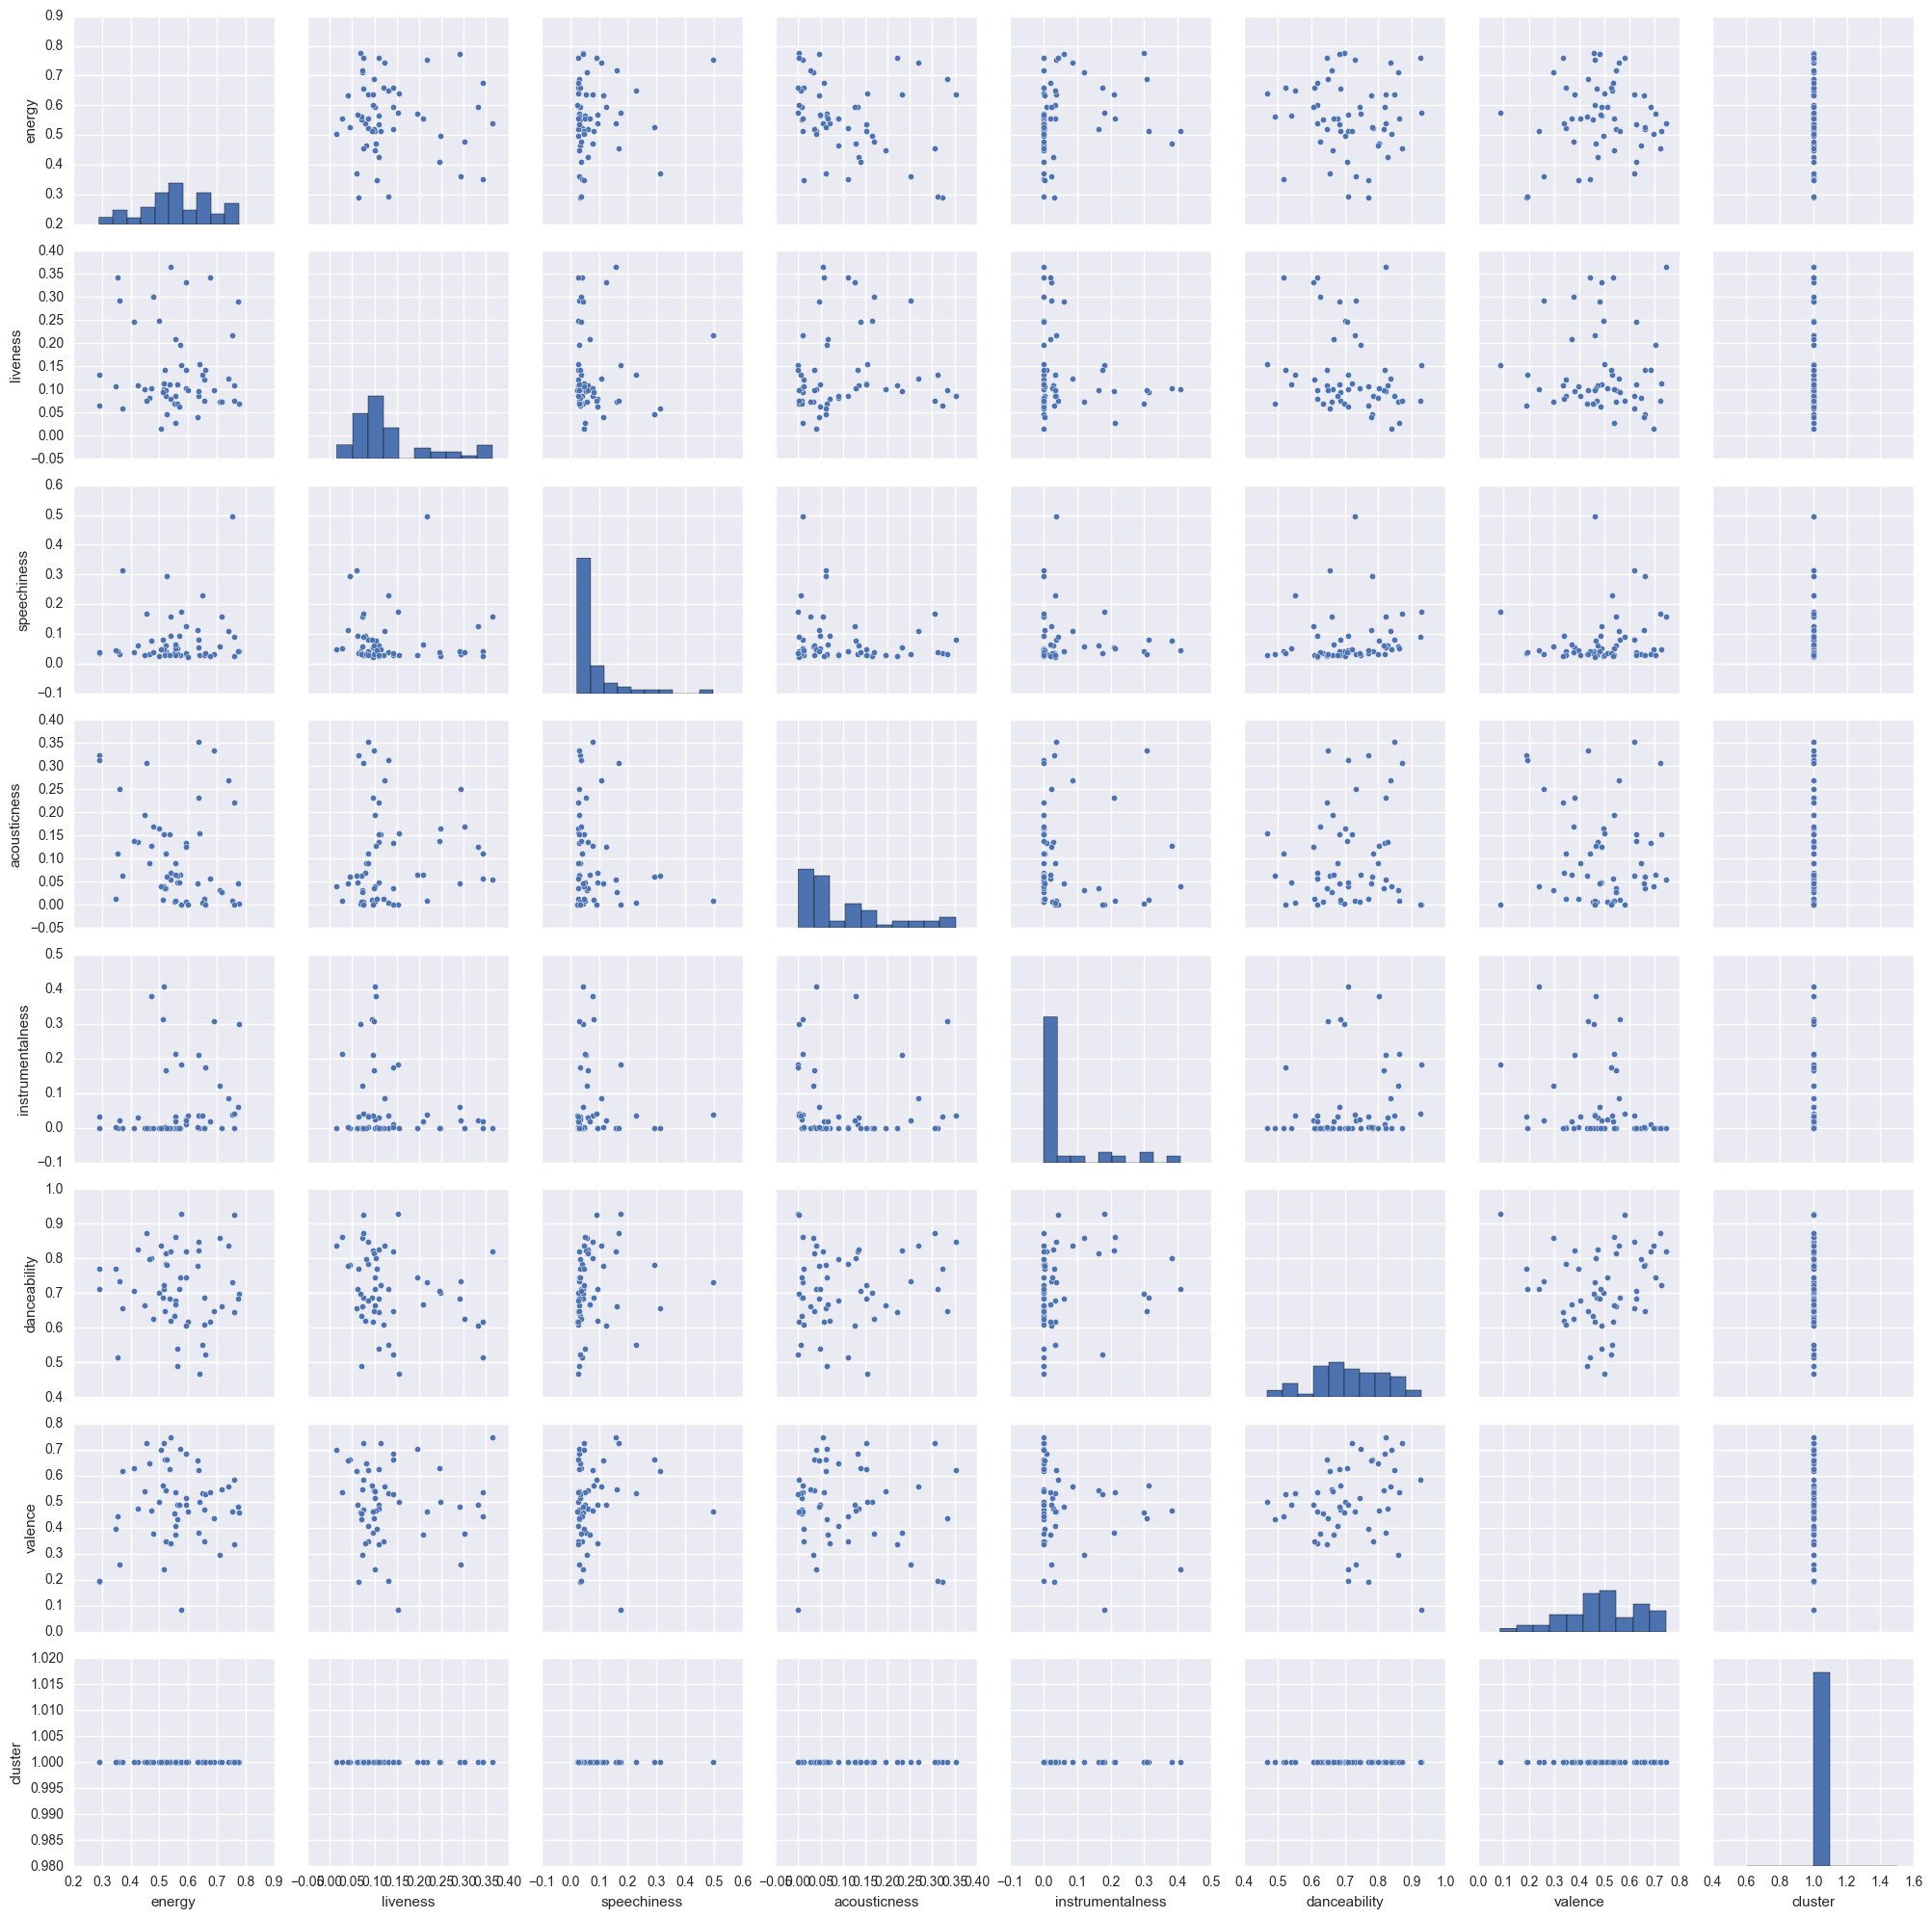

In [21]:
sns.pairplot(cluster_1_df)

Looks decent, still we would like to have a better overall view of the different clusters. 

## Dimensional Reduction

The way to go here is to use dimensional reduction to map our higher dimensional problem down to 2 dimensions. This makes it a lot easier to generate visualisations that our human brain can actually understand.

### PCA

We can use PCA to reduce the number of dimensions

In [22]:
from sklearn.decomposition import PCA

In [28]:
%%time
x_feat = clustered_features_df.drop(['id', 'uri', 'cluster'], axis=1)
pca = PCA(n_components=2)

pca_result = pca.fit_transform(x_feat)

clustered_features_df['pca-one'] = pca_result[:,0]
clustered_features_df['pca-two'] = pca_result[:,1] 
# clustered_features_df['pca-three'] = pca_result[:,2]

print('Explained variation per principle component: {}'.format(pca.explained_variance_ratio_))



Explained variation per principle component: [ 0.94561785  0.03078189]
CPU times: user 16.1 ms, sys: 3.91 ms, total: 20 ms
Wall time: 5.96 ms


These two components account for 97% of the variation in the dataset.

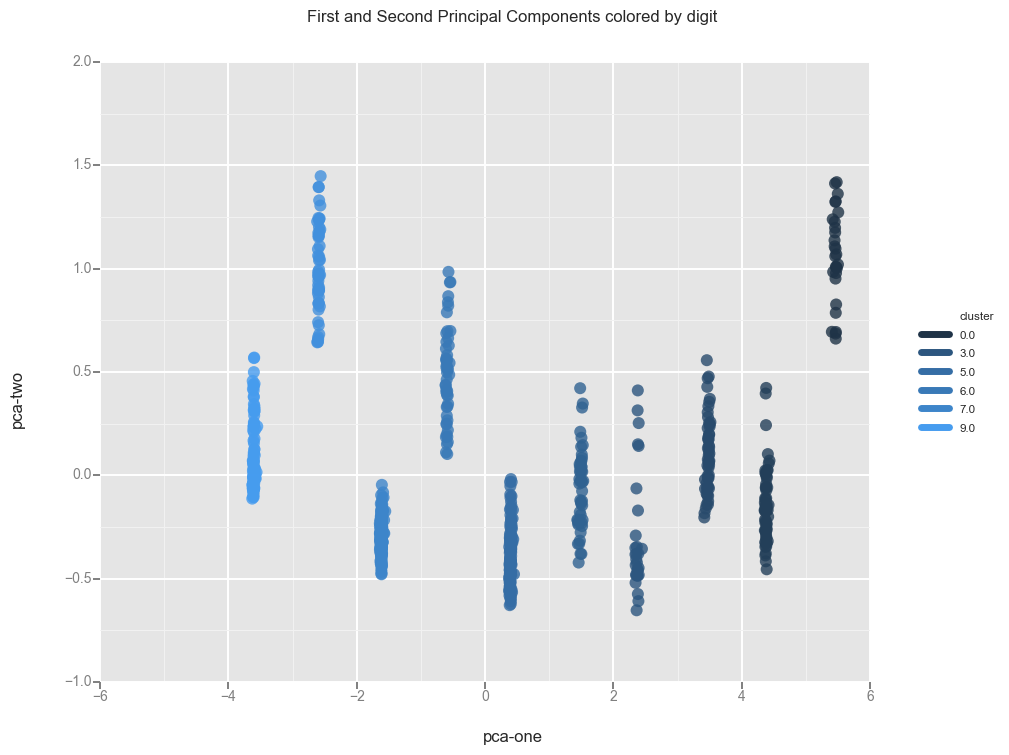

<ggplot: (312230811)>

In [30]:
from ggplot import *

chart = ggplot( clustered_features_df, aes(x='pca-one', y='pca-two', color='cluster') ) \
        + geom_point(size=75,alpha=0.8) \
        + ggtitle("First and Second Principal Components colored by digit")
chart

## T-SNE

In [25]:
import time
from sklearn.manifold import TSNE

In [26]:
x_feat = clustered_features_df.drop(['id', 'uri'], axis=1)

time_start = time.time()

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(x_feat)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 705 / 705
[t-SNE] Mean sigma: 0.178484
[t-SNE] KL divergence after 100 iterations with early exaggeration: 0.400736
[t-SNE] Error after 175 iterations: 0.400736
t-SNE done! Time elapsed: 4.280985116958618 seconds


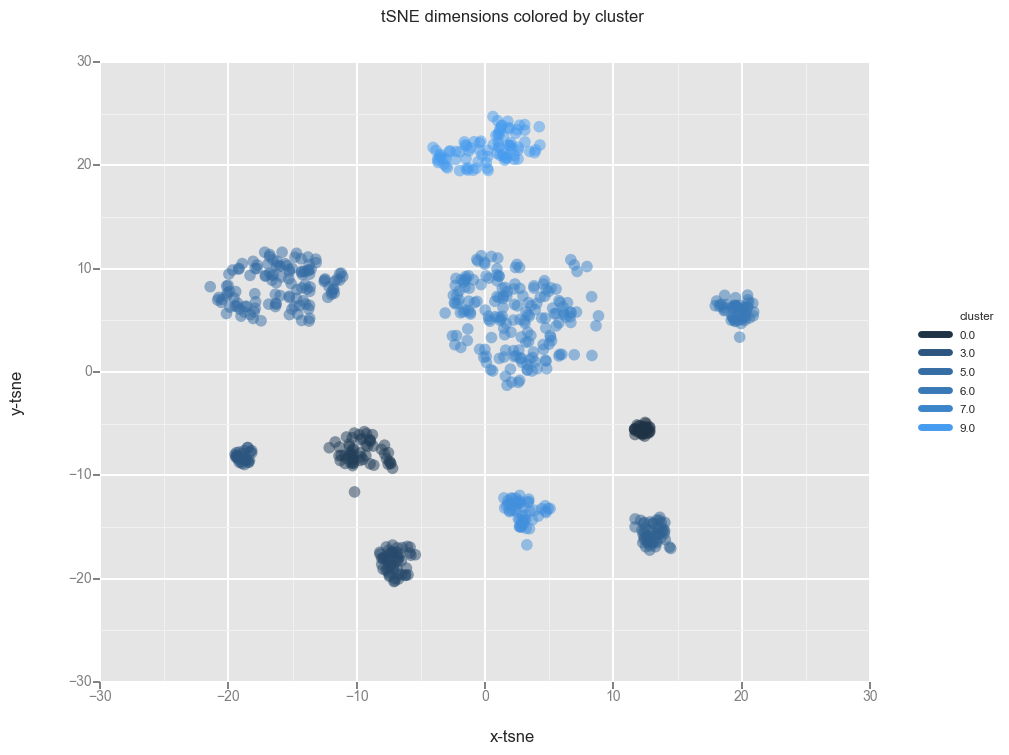

<ggplot: (-9223372036535037226)>

In [27]:
x_feat['x-tsne'] = tsne_results[:, 0]
x_feat['y-tsne'] = tsne_results[:, 1]

chart = ggplot(x_feat, aes(x='x-tsne', y='y-tsne', color= 'cluster')) \
        + geom_point(size=70,alpha=0.5) \
        + ggtitle("tSNE dimensions colored by cluster")
chart